<a href="https://colab.research.google.com/github/fernandofsilva/thesis/blob/main/Pr%C3%A9_processamento_dos_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
#@title Carregar as bibliotecas bases
import pandas as pd
import numpy as np
import math

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style('whitegrid')

Os dados desse trabalho foram retirados diretamente do [site da B3](http://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/historico/mercado-a-vista/cotacoes-historicas/), a B3 disponibiliza os arquivos por ano com as cotações diárias de todos ativos negociados por ela.

O arquivo Csv carregado na próxima célula já foi processado utilizando o pacote [Bovespa](https://github.com/fernandofsilva/bovespa), a versão do link é uma versão modificada por mim, o pacote original é antigo e possui alguns erros e rótulos desatualizados, se você quiser acessar a versão original do pacote esse é o [link](https://pypi.org/project/bovespa/).

In [2]:
#@title Carregando os dados de cotações da B3 com o periódo de 2015 até 2020.
raw_data = pd.read_csv('/content/drive/My Drive/Datasets/cotacao.csv.gz')
raw_data.head()

,TIPREG,DATPRG,CODBDI,CODNEG,TPMERC,NOMRES,ESPECI,PRAZOT,MODREF,PREABE,PREMAX,PREMIN,PREMED,PREULT,PREOFC,PREOFV,TOTNEG,QUATOT,VOLTOT,PREEXE,INDOPC,DATVEN,FATCOT,PTOEXE,CODISI,DISMES
0,1,2015-01-02,2,AAPL34,10,APPLE,DRN,NaN,R$,29.65,29.65,29.45,29.61,29.45,29.20,0.00,2,32300,9.564350e+05,0.0,0,9999-12-31,1,0,BRAAPLBDR004,111
1,1,2015-01-02,2,ABCB4,10,ABC BRASIL,PN EJS N2,NaN,R$,12.85,12.85,12.35,12.54,12.55,12.55,12.56,531,117100,1.469337e+06,0.0,0,9999-12-31,1,0,BRABCBACNPR4,123
2,1,2015-01-02,96,ABCB4F,20,ABC BRASIL,PN EJS N2,NaN,R$,12.83,12.83,12.48,12.69,12.48,12.53,12.86,5,208,2.641260e+03,0.0,0,9999-12-31,1,0,BRABCBACNPR4,123
3,1,2015-01-02,12,ABCP11,10,FII ABC IMOB,CI ER,NaN,R$,9.72,9.72,8.01,9.64,9.64,9.31,9.64,9,496,4.781490e+03,0.0,0,9999-12-31,1,0,BRABCPCTF000,231
4,1,2015-01-02,2,ABEV3,10,AMBEV S/A,ON EJ,NaN,R$,16.14,16.56,15.77,16.08,16.01,15.91,16.01,21543,19110800,3.073420e+08,0.0,0,9999-12-31,1,0,BRABEVACNOR1,106


# PETR4

O foco desse trabalho é utilizando o ativo PETR4 e as opções do ativo subjacente.

In [3]:
#@title Filtrando o dataset e selecionando apenas o ativo PETR4
# Filter data
spot = raw_data[raw_data['CODNEG'] == 'PETR4']

# Dict to rename the columns
dict_ref = {
    'DATPRG': 'date',
    'PREULT': 'S'
}

# Rename the columns and subset
spot = spot.rename(columns=dict_ref)
spot = spot[dict_ref.values()]

# Format and subset date
spot['date'] = pd.to_datetime(spot['date'])
spot = spot.sort_values(by='date')
spot.index = spot['date']
spot = spot.drop(['date'], axis=1)

spot.head()

,S
date,
2015-01-02,9.36
2015-01-05,8.61
2015-01-06,8.33
2015-01-07,8.67
2015-01-08,9.18


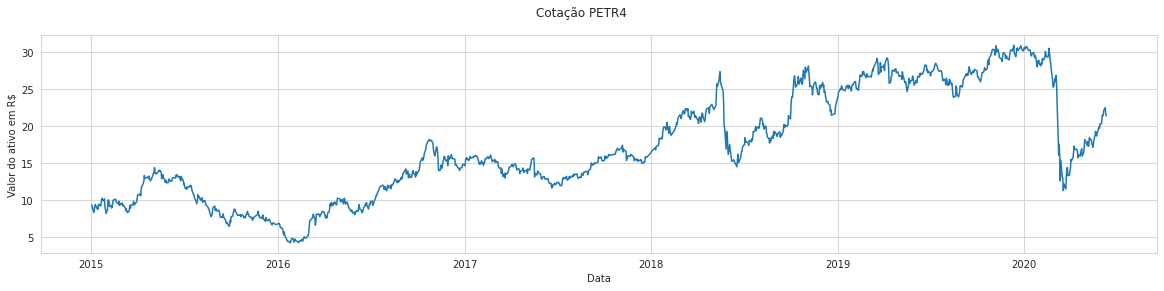

In [4]:
#@title Plot com os dados selecionados
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('Cotação PETR4')
ax.plot(spot['S'])
ax.set_ylabel('Valor do ativo em R$')
ax.set_xlabel('Data')
plt.show()

# Opções

Selecionada somente os dados de opções e ajustados os rótulos de acordo com [guia](http://www.b3.com.br/data/files/33/67/B9/50/D84057102C784E47AC094EA8/SeriesHistoricas_Layout.pdf) fornecido pela B3.

In [5]:
#@title Processamento dos dados de opções
# Dict to rename the columns
dict_ref = {
    'DATPRG': 'date',
    'CODNEG': 'option',
    'PREULT': 'value',
    'PREEXE': 'X',
    'DATVEN': 'expire',
    'TPMERC': 'option_type'
}

# Rename the columns
option = raw_data.rename(columns=dict_ref)

# Filter options data
option = option[option['option_type'].isin([70, 80])]
option = option[option['option'].str.startswith('PETR')]
option = option[dict_ref.values()]

# Dict symbol type
TPMERC = {70: 'call', 80: 'put'}

# Replace options types
option['option_type'] = option['option_type'].replace(TPMERC)
option.head()

,date,option,value,X,expire,option_type
915,2015-01-02,PETRA1,0.13,10.66,2015-01-19,call
916,2015-01-02,PETRA10,1.00,8.61,2015-01-19,call
917,2015-01-02,PETRA11,0.02,21.00,2015-01-19,call
918,2015-01-02,PETRA12,0.02,12.91,2015-01-19,call
919,2015-01-02,PETRA13,0.01,13.91,2015-01-19,call


A variável T  é dada pelo fração do tempo em formato anual, entre o dia da cotação até o vencimento da opção.

In [6]:
#@title Cálculo da variável T
# Get unique days
workday = pd.DataFrame({'day': option['date'].unique()})
workday['day'] = pd.to_datetime(workday['day'])
workday = workday.sort_values(by='day')

# Create T
T = list()

for index, row in option.iterrows():
    T.append(workday[(workday['day'] >= row.date) & (workday['day'] <= row.expire)].shape[0] - 1)

option['T'] = T
option['T'] = option['T'] / 252

# Format and subset date
option['date'] = pd.to_datetime(option['date'])
option['expire'] = pd.to_datetime(option['expire'])
option = option.sort_values(by='date')

# Set index
option.index = option['date']
option = option.drop(['date'], axis=1)

option.head()

,option,value,X,expire,option_type,T
date,,,,,,
2015-01-02,PETRA1,0.13,10.66,2015-01-19,call,0.043651
2015-01-02,PETRL44,0.50,17.00,2015-12-21,call,0.952381
2015-01-02,PETRM1,1.34,10.66,2015-01-19,put,0.043651
2015-01-02,PETRM10,0.19,8.61,2015-01-19,put,0.043651
2015-01-02,PETRM12,3.58,12.91,2015-01-19,put,0.043651


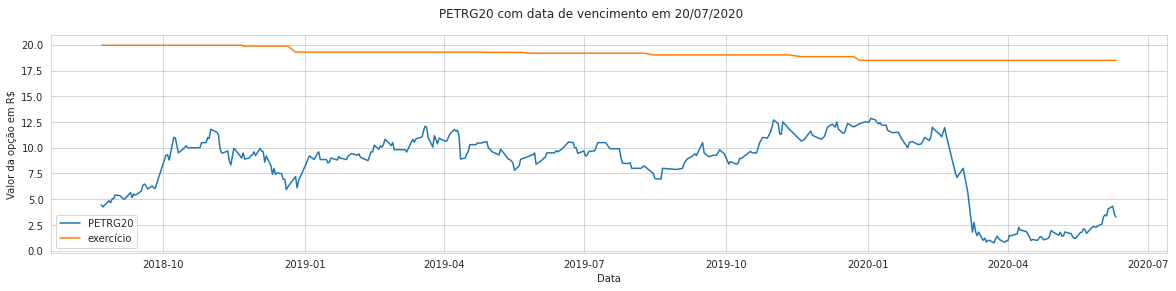

In [7]:
#@title Plot dos dados da opção PETRG20
# Plot
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('PETRG20 com data de vencimento em 20/07/2020')
ax.plot(option.loc[(option['option'] == 'PETRG20') & (option['expire'] == '2020-07-20'), 'value'], label='PETRG20')
ax.plot(option.loc[(option['option'] == 'PETRG20') & (option['expire'] == '2020-07-20'), 'X'], label='exercício')
ax.set_ylabel('Valor da opção em R$')
ax.set_xlabel('Data')
ax.legend()
plt.show()

# CDI

Os dados do CDI são retirados diretamente do [Banco Central](https://www.bcb.gov.br/htms/SELIC/SELICdiarios.asp?frame=1), nesse trabalho utilizamos o valor de taxa básica de juros livre de risco (cupom limpo, significa que é utilizada da taxa de último dia do mês, isso porque durante o mês a taxa pode ser negativa)

In [8]:
#@title Dados de CDI do Banco Central
cdi = pd.read_csv('/content/drive/My Drive/Datasets/cdi.csv', usecols=['date', 'cdi'])

In [9]:
#@title Format CDI Data
# Format and subset date
cdi['date'] = pd.to_datetime(cdi['date'], format='%d/%m/%y')
cdi = cdi.sort_values(by='date')

# Filter using the first date
cdi = cdi[cdi['date'].dt.month != cdi['date'].dt.month.shift(1)]

# Create date range
date = pd.DataFrame({'date': pd.date_range(start='1/1/2015', end='12/31/2020')})

# Merge with cdi
date = date.merge(right=cdi, how='left', on='date')

# Fill Nan
date['cdi'] = date['cdi'].fillna(method='ffill')
cdi = date.dropna()

# Create index
cdi = cdi.rename(columns={'cdi': 'r'})
cdi.index = cdi['date']
cdi = cdi.drop(['date'], axis=1)
cdi.head()

,r
date,
2015-01-02,11.57
2015-01-03,11.57
2015-01-04,11.57
2015-01-05,11.57
2015-01-06,11.57


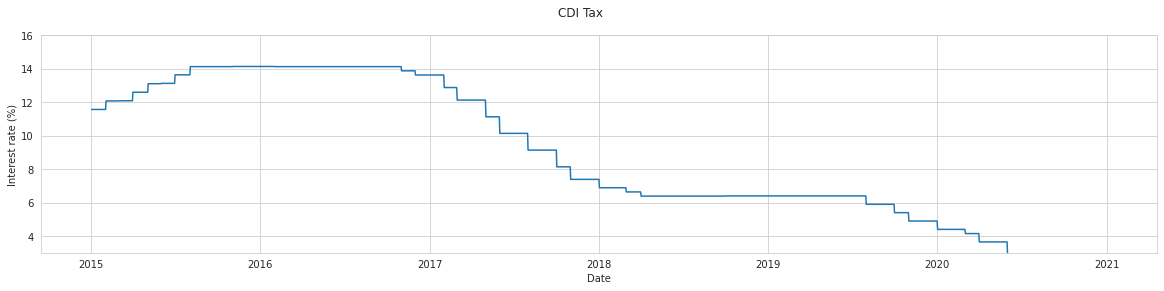

In [10]:
#@title Plot CDI Data
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('CDI Tax')
ax.plot(cdi)
ax.set_ylabel('Interest rate (%)')
ax.set_ylim(3, 16)
ax.set_xlabel('Date')
plt.show()

# GARCH (1,1)

Para o cálculo do valor da opção, também necessário estimar o valor da volitilidade no período, a volitilidade é estimada a partir dos retornos do ativo, dado pela fórmula $\ln\left(\dfrac{S_{i}}{S_{i-1}}\right)$ onde $S$ é o valor do ativo e $i$ o dia.

In [11]:
#@title Cálculo de retornos PETR4
spot['return'] = np.log(spot['S'] / spot['S'].shift(1))
spot = spot.dropna()
spot.head()

,S,return
date,,
2015-01-05,8.61,-0.083521
2015-01-06,8.33,-0.033061
2015-01-07,8.67,0.040005
2015-01-08,9.18,0.057158
2015-01-09,9.40,0.023682


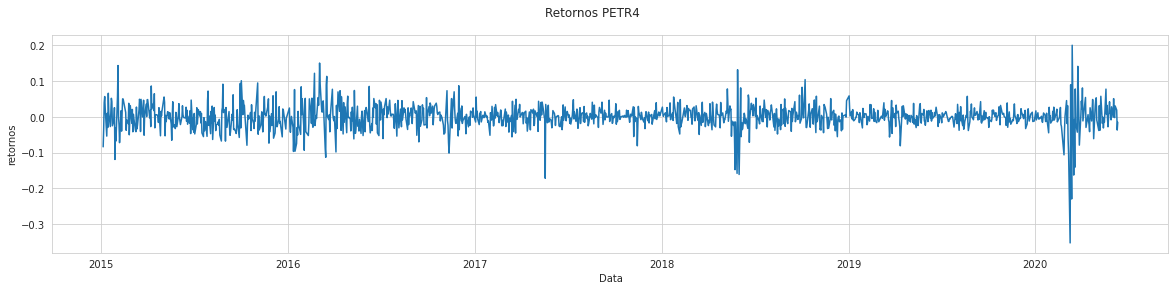

In [12]:
#@title Plot dos retornos de PETR4
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('Retornos PETR4')
ax.plot(spot['return'])
ax.set_ylabel('retornos')
ax.set_xlabel('Data')
plt.show()

In [13]:
#@title instalação do pacote arch para modelagem da volatilidade
!pip install arch

In [14]:
#@title Modelagem de volitidade por Garch(1,1)
from arch import arch_model

am = arch_model(spot['return'], p=1, o=0, q=1)
res = am.fit(update_freq=5)
garch = res.conditional_volatility * math.sqrt(252) * 100
garch = garch.rename("sigma")
print(res.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2818.1945447644266
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 4
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                2818.19
Distribution:                  Normal   AIC:                          -5628.39
Method:            Maximum Likelihood   BIC:                          -5607.58
                                        No. Observations:                 1343
Date:                Tue, Nov 03 2020   Df Residuals:                     1339
Time:                        22:25:07   Df Model:                            4
                                  Mean Model                                 
 

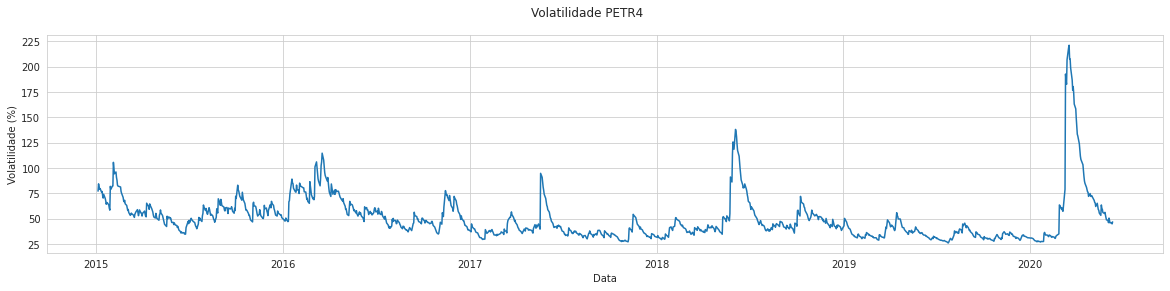

In [15]:
#@title Plot Volatilidade
fig, axs = plt.subplots(figsize=(20, 4))
fig.suptitle('Volatilidade PETR4')
axs.plot(garch)
axs.set_ylabel('Volatilidade (%)')
axs.set_xlabel('Data')
plt.show()

# Junção dos dados

In [16]:
#@title Junção entre as bases PETR4, Opções, CDI e GARCH
data = option.merge(right=spot, right_index=True, left_index=True)
data = data.merge(right=cdi, right_index=True, left_index=True)
data = data.merge(right=garch, right_index=True, left_index=True)
data = data.rename(columns={'cond_vol': 'vol'})
data.head()

,option,value,X,expire,option_type,T,S,return,r,sigma
date,,,,,,,,,,
2015-01-05,PETRM2,0.02,4.91,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396
2015-01-05,PETRM23,0.79,9.21,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396
2015-01-05,PETRM25,1.13,9.61,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396
2015-01-05,PETRM51,0.15,7.61,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396
2015-01-05,PETRM16,7.13,15.91,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396


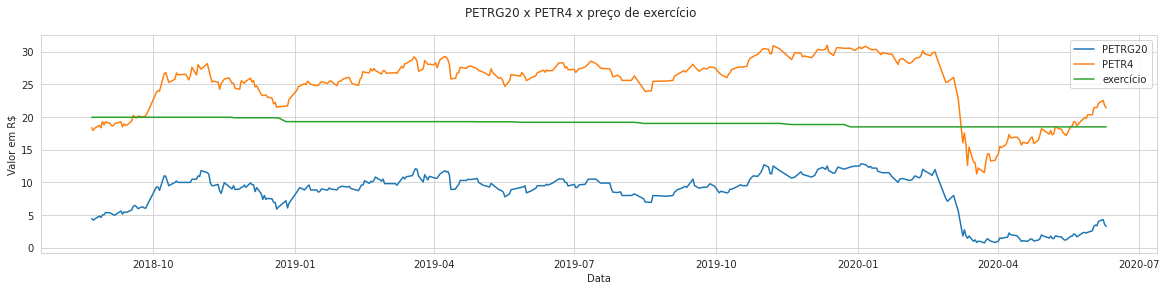

In [17]:
#@title Plot dos dados juntos
# Plot
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('PETRG20 x PETR4 x preço de exercício')
ax.plot(data.loc[(data['option'] == 'PETRG20') & (data['expire'] == '2020-07-20'), 'value'], label='PETRG20')
ax.plot(data.loc[(data['option'] == 'PETRG20') & (data['expire'] == '2020-07-20'), 'S'], label='PETR4')
ax.plot(data.loc[(data['option'] == 'PETRG20') & (data['expire'] == '2020-07-20'), 'X'], label='exercício')
ax.set_ylabel('Valor em R$')
ax.set_xlabel('Data')
ax.legend()
plt.show()

# Black-Scholes

O cálculo fórmula de Black-Scholes de uma opção de compra é dado pela equação $C(t, T) = S(t)N(d_{1}) - Ke^{-r(T-t))}N(d_{2})$ e venda $P(t, T) = Ke^{-r(T-t))}N(-d_{2}) - S(t)N(-d_{1})$, onde $d_{1} = \frac{\ln\bigg({\frac{S(t)}{K}}\bigg)+\bigg(r+\frac{\sigma^{2}}{2}\bigg)(T-t)}{\sigma\sqrt{T-t}}$ e $d_{2} = \frac{\ln\bigg({\frac{S(t)}{K}}\bigg)+\bigg(r-\frac{\sigma^{2}}{2}\bigg)(T-t)}{\sigma\sqrt{T-t}}$.

In [18]:
#@title Formula
from scipy.stats import norm

# Auxiliary function for d_one risk-adjusted probability
def d11(S, X, T, r, sigma):
    """This is an auxiliary function and is not intended to be called externally."""
    return (np.log(S/X) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))

# Auxiliary function for d_two risk-adjusted probability
def d21(d1, T, sigma):
    """This is an auxiliary function and is not intended to be called externally."""
    return d1 - sigma * np.sqrt(T)

# Definition of the Black-Scholes delta function
def bs_delta(S, X, T, r, sigma, option_type):
    """Compute the delta of the Black-Scholes option pricing formula.

    Arguments:
    S           -- the current spot price of the underlying stock
    X           -- the option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- the risk-free interest rate
    sigma       -- the returns volatility of the underlying stock
    option_type -- the option type, either 'call' or 'put'

    Returns: a numpy.float_ representing the delta value
    Exceptions raised: ValueError if option_type is not 'call' or 'put'
    """
    if option_type == 'call':
        return norm.cdf(d11(S, X, T, r, sigma))
    elif option_type == 'put':
        return norm.cdf(-d11(S, X, T, r, sigma))
    else:
        # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type is either 'call' or 'put'.")

# Definition of the Black-Scholes European option pricing formula
def black_scholes(S, X, T, r, sigma, option_type):
    """Price a European option using the Black-Scholes option pricing formula.

    Arguments:
    S           -- the current spot price of the underlying stock
    X           -- the option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- the risk-free interest rate
    sigma       -- the returns volatility of the underlying stock
    option_type -- the option type, either 'call' or 'put'

    Returns: a numpy.float_ representing the option value
    Exceptions raised: ValueError if option_type is not 'call' or 'put'
    """
    d_one = d11(S, X, T, r, sigma)
    d_two = d21(d_one, T, sigma)
    if option_type == 'call':
        return S * norm.cdf(d_one) - np.exp(-r * T) * X * norm.cdf(d_two)
    elif option_type == 'put':
        return -(S * norm.cdf(-d_one) - np.exp(-r * T) * X * norm.cdf(-d_two))
    else:
        # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type is either 'call' or 'put'.")

def bs_pandas(row):
    value = black_scholes(
        row['S'], row['X'], row['T'], row['r']/100, row['sigma']/100, row['option_type']
    )
    return round(value, 2)

def delta_pandas(row):
    value = bs_delta(
        row['S'], row['X'], row['T'], row['r']/100, row['sigma']/100, row['option_type']
    )
    return int(round(value * 100, 0))

data['bs'] = data.apply(bs_pandas, axis=1)
data['delta_bs'] = data.apply(delta_pandas, axis=1)
data.head()

,option,value,X,expire,option_type,T,S,return,r,sigma,bs,delta_bs
date,,,,,,,,,,,,
2015-01-05,PETRM2,0.02,4.91,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396,0.00,0
2015-01-05,PETRM23,0.79,9.21,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396,0.87,63
2015-01-05,PETRM25,1.13,9.61,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396,1.16,73
2015-01-05,PETRM51,0.15,7.61,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396,0.14,18
2015-01-05,PETRM16,7.13,15.91,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396,7.23,100


# Save to file

In [25]:
#@title Salvar arquivo processado para Rede Neural (DNN)
# Save file to Csv
data.to_csv(f'/content/drive/My Drive/Datasets/data_option_dnn.csv')

Diferente da rede neural que trata os dados de forma independente no tempo, a rede LSTM utiliza das sequências de dados para fazer a predição dos valores, com isso é adicionada uma nova dimensão nos dados (tempo ou qualquer dado que seja sequencial).

Algumas opções não são negociadas todos os dias e também há opções com diferentes tamanhos de tempo (opções de 1 mês, 2 meses e até mais de um ano). Mesmo que as redes recorrentes aceitem dimensões de tempos diferentes no treinamento, testes anteriores mostraram um grande esforço para dimensionamento e inserção desses dados na rede e resultados poucos satisfatórios com essa abordagem.

Com isso foi padronizado um tamanho de dados de 50 dias. Assim, opções com dias de negócio menor que 50, tiveram seu tamanho alongado através de padding, ou seja, foram adicionadas dados em branco para que a janela de tempo fosse fixa em 50 dias, isso não prejudicou o treinamento, uma vez que não há valores de opção R$ 0.00

In [21]:
#@title Padding com time steps de 50 dias
# Reset index
data = data.reset_index()

# Create reference dataframe
reference = data.groupby(['expire', 'option', 'option_type'], as_index=False).agg({'sigma': 'count'})
reference = reference.drop(['sigma'], axis=1)

# Create empty dataframe to append data
df = pd.DataFrame()

# Loop over the reference dict
for index, row in reference.iterrows():

    # Filter the data according the options
    subset = data[(data['expire'] == row['expire']) & (data['option'] == row['option'])]

    # Calcule the size of the data
    size = 50 - subset.shape[0]

    if size > 0:
        # Create padding data
        subset = pd.DataFrame({'date': pd.date_range(start='1/1/2014', periods=size),
                    'option': [row['option']] * size,
                    'value': [0] * size,
                    'X': [0] * size,
                    'expire': [row['expire']] * size,
                    'option_type': [row['option_type']] * size,
                    'T': [0] * size,
                    'S': [0] * size,
                    'volume': [0] * size,
                    'r': [0] * size,
                    'sigma': [0] * size,
                    'bs': [0] * size,
                    'delta_bs': [0] * size
        }).append(subset)
    else:
        subset = subset[-50:]

    # Append in the dataframe
    df = df.append(subset)

# Order dataframe
df = df.sort_values(by=['expire', 'option', 'date'])

In [24]:
#@title Salvar arquivo processado para Rede Recorrente (LSTM)
df.to_csv(f'/content/drive/My Drive/Datasets/data_option_lstm.csv', index=False)